### plot features over UMAP data

#### biosound features
https://www.nature.com/articles/s41467-018-06394-9
https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06394-9/MediaObjects/41467_2018_6394_MOESM1_ESM.pdf
- The PAF (predefined acoustic features) consisted of 18 features describing the spectral
(8), temporal (5) and fundamental (5) characteristics of each sound (see also (1)). The spectral
features were extracted from the frequency power spectrum (called spectral envelope here). The
spectral envelope was estimated using Welch’s average periodogram (window = 49 ms, 50%
overlap, Hanning window). From the normalized spectral envelope (to have unit integral), we
calculated the first moments: the mean spectrum, the spectral standard deviation (i.e. the spectral
bandwidth), the spectral skew and the spectral kurtosis. To capture an overall measure of spectral 
envelope variability, we also calculated the spectral entropy. Finally, we also calculated the 3
quartiles (the 25% quartile, the median and 75% quartile) as these are often used in bioacoustical
analyses. A temporal envelope was estimated by rectifying the sound pressure waveform and
low-pass filtering at 20 Hz. From the normalized temporal envelope, we obtained the temporal
mean, the temporal standard deviation (i.e. the duration), the temporal skew and temporal
kurtosis. Overall variability was quantified with the temporal entropy. Five fundamental
parameters were obtained from a time-varying estimation of the instantaneous fundamental
frequency (1 kHz sampling). 
The fundamental (F0) was estimated using a hybrid
temporal/spectral approach: the auto-correlation function of the signal was first analyzed to
estimate the period of F0 based on the largest non-zero time-lagged peak in the auto-correlation
function with a frequency below 1500Hz; this initial estimate was then used as an initial guess
for matching the spectral periodicity found in the spectrogram at the corresponding time window
(see Elie and Theunissen, 2016, for more details). The ratio of amplitude of the non-zero delay
peak in the auto-correlation function with the peak at zero delay was used to estimate the
periodicity of the sound at each time point. The pitch saliency of each vocalization was taken as
the average value of this amplitude ratio over time points. F0 was only estimated for periodic
time points showing values of pitch saliency above 0.5. In addition, we obtained the mean F0,
the min F0, the max F0, and the coefficient of variation of F0. Equations and additional details
for the calculations of PAF can be found in Elie and Theunissen (2016). Note that in this
analysis, we did not use any features that described the intensity of the sound (e.g. RMS, peak
amplitude) because these might have been affected by systematic differences in the position of
the birds relative to the microphone and could bias the classifier for discriminating vocalizer
identity. In some of our analyses, we used only the 8 spectral or only the 5 temporal or only the 5
fundamental features in the classifiers in order to compare the relative importance of these three
types of acoustic features.
#### spectral characteristics (8)
- calculated from frequency power spectrum
1. the mean spectrum
2. the spectral standard deviation (i.e. the spectral
bandwidth)
3. the spectral skew 
4. spectral kurtosis
5. spectral entropy
6. 25% quartile
7. the median 
8. 75% quartile
#### temporal characteristics (5)
- calculated from temporal envelope (rectify waveform and low pass at 20hz)
1. temporal mean
2. temporal standard deviation (duration)
3. temporal skew
4. temporal kurtosis
5. temporal entropy
#### fundamental characteristics (5)
- calculated from time varying estimation of fundamental frequency (f0 was estimated using hybrid temporal/spectral approach)
1. pitch saliency (average value of this amplitude ratio over time points)
2. mean F0
3. min F0
4. max F0
5. coefficient of variation of F0

In [3]:
biosound_features = {
    "f0 features": {
        "fund": "Mean F0 (Hz)",
        "coefficient of variation of F0": "cvfund",
        "maxfund": "Min. F0 (Hz)",
        "minfund": "Max. F0 (Hz)",
        "F1": "First formant (Hz)",
        "sal": "Pitch saliency",
    },
    "intensity features": {
        "rms": "Root Mean Squared (amp.)",
        "maxAmp": "Max  amplitude",
    },
    "spectral features": {
        "meanS": "Spectral mean  (Hz)",
        "stdS": "Spectral std.  (Hz)",
        "skewS": "Spectral skewness",
        "kurtS": "Spectral Kurtosis",
        "entS": "Spectral entropy (0-1)",
        "q1": "Spectral Q1 (Hz)",
        "q2": "Spectral Q2 (Hz)",
        "q3": "Spectral Q3 (Hz)",
    },
    "temporal features": {
        # temporal centroid for the temporal envelope
        "meanT": "Mean time (ms)",  
        "stdT": "Time Std. (ms)",
        "skewT": "Time Skewness",
        "kurtT": "Time Kurtosis",
        "entT": "Time entropy (0-1)",
    }
}

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [8]:
from soundsig.sound import BioSound 

In [9]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

### Collect data

In [10]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [11]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins-biosound-features.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins-biosound-features.pickle')

In [12]:
syllable_df = pd.read_pickle(df_loc)

In [13]:
syllable_df[:3]

index  start_time   end_time labels indv  indvi subject_importance  \
0      0    9.842790  10.105938     ah  ORA      0    Primary subject   
1      1   72.031245  72.346332     ah  ORA      0    Primary subject   
2      2   74.130176  74.376012     bz  ORA      0    Primary subject   

                          key  \
0  2014-05-29_10-10-00-000000   
1  2014-05-29_10-10-00-000000   
2  2014-05-29_10-10-00-000000   

                                               audio   rate  ...      kurtS  \
0  [-0.19927763130383222, -0.2129138251615996, -0...  44100  ...  16.696955   
1  [-0.12207342570633199, -0.09996911527363203, -...  44100  ...  27.281679   
2  [-0.0889848557398444, -0.06770700742932487, -0...  44100  ...   6.511656   

       entS           q1           q2           q3     meanT      stdT  \
0  0.617858  2928.515625  3359.179688  3660.644531  0.144487  0.062899   
1  0.555706  2928.515625  3316.113281  3445.312500  0.168187  0.073403   
2  0.620362  3445.312500  3574.511719  3746.777344  0.129396  0.070895   

      skewT     kurtT      entT  
0 -0.093658  2.219679  0.980332  
1 -0.040624  2.230751  0.979186  
2 -0.121606  1.725413  0.994918  

[3 rows x 37 columns]

In [14]:
syllable_df.columns

Index(['index', 'start_time', 'end_time', 'labels', 'indv', 'indvi',
       'subject_importance', 'key', 'audio', 'rate', 'spectrogram', 'syll_len',
       'nsamp', 'index', 'fund', 'cvfund', 'maxfund', 'minfund', 'F1', 'F2',
       'F3', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS', 'kurtS', 'entS',
       'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT', 'entT'],
      dtype='object')

### Subset most frequent syllables

In [15]:
import seaborn as sns

In [16]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [17]:
top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

en    au    ce    cj    ah    bm    ch    ai    db    aj    ck    hg  \
0  2995  2077  1620  1506  1418  1378  1363  1362  1357  1305  1233  1180   

     ac    ci    fq    ec   df   bx   cr   cl  
0  1179  1080  1007  1003  986  984  978  971

In [18]:
subset_df= syllable_df[syllable_df.labels.isin(top_labels.columns)]
subset_df[:3]

index  start_time    end_time labels indv  indvi subject_importance  \
0       0    9.842790   10.105938     ah  ORA      0    Primary subject   
1       1   72.031245   72.346332     ah  ORA      0    Primary subject   
12     12  114.757543  114.986067     bm  ORA      0    Primary subject   

                           key  \
0   2014-05-29_10-10-00-000000   
1   2014-05-29_10-10-00-000000   
12  2014-05-29_10-10-00-000000   

                                                audio   rate  ...      kurtS  \
0   [-0.19927763130383222, -0.2129138251615996, -0...  44100  ...  16.696955   
1   [-0.12207342570633199, -0.09996911527363203, -...  44100  ...  27.281679   
12  [-0.03662450122476042, -0.022604548403189744, ...  44100  ...   6.794279   

        entS           q1           q2           q3     meanT      stdT  \
0   0.617858  2928.515625  3359.179688  3660.644531  0.144487  0.062899   
1   0.555706  2928.515625  3316.113281  3445.312500  0.168187  0.073403   
12  0.566811  3359.179688  3531.445312  3746.777344  0.113123  0.057371   

       skewT     kurtT      entT  
0  -0.093658  2.219679  0.980332  
1  -0.040624  2.230751  0.979186  
12  0.229053  1.837216  0.966494  

[3 rows x 37 columns]

In [19]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(26982, 992)

### mask training and test data

In [20]:
train_mask = np.random.binomial(n=1, p=0.5, size=len(specs)) == True
test_mask = train_mask==False

### Get syllable features

In [21]:
biosound_features = {
    "f0 features": {
        "fund": "Mean F0 (Hz)",
        "cvfund": "Coeff. var. F0 (0-1)",
        "maxfund": "Min. F0 (Hz)",
        "minfund": "Max. F0 (Hz)",
        "F1": "First formant (Hz)",
        "sal": "Pitch saliency",
    },
    "intensity features": {
        "rms": "RMS (amp.)",
        "maxAmp": "Max  amplitude",
    },
    "spectral features": {
        "meanS": "Spectral mean  (Hz)",
        "stdS": "Spectral std.  (Hz)",
        "skewS": "Spectral skewness",
        "kurtS": "Spectral Kurtosis",
        "entS": "Spectral entropy (0-1)",
        "q1": "Spectral Q1 (Hz)",
        "q2": "Spectral Q2 (Hz)",
        "q3": "Spectral Q3 (Hz)",
    },
    "temporal features": {
        # temporal centroid for the temporal envelope
        "meanT": "Mean time (ms)",  
        "stdT": "Time Std. (ms)",
        "skewT": "Time Skewness",
        "kurtT": "Time Kurtosis",
        "entT": "Time entropy (0-1)",
    }
}

In [18]:
"""features = [
    "fund","cvfund", "maxfund","minfund","F1", "sal", # "F3",
    "rms","maxAmp","meanS","stdS","skewS","kurtS","entS",
    "q1","q2","q3","meanT","stdT","skewT","kurtT","entT", "syll_len"]
#features = ['F1', 'F2', 'F3', 'sal', 'fund','cvfund', 'syll_len']"""

In [24]:
features = ["fund", "cvfund", "maxfund", "minfund", "sal"] + [
    "meanS", "stdS", "skewS", "kurtS", "entS", "q1", "q2", "q3"
] + ["meanT", "stdT", "skewT", "kurtT", "entT"]

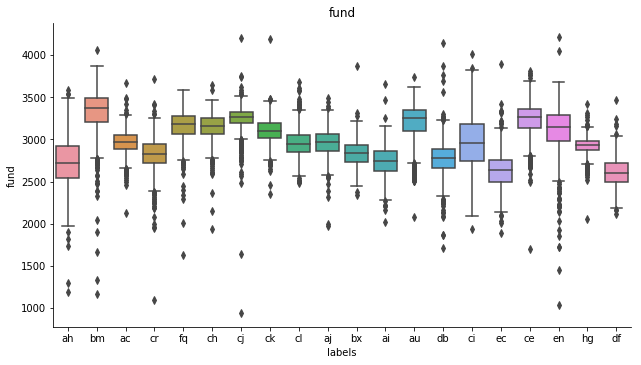

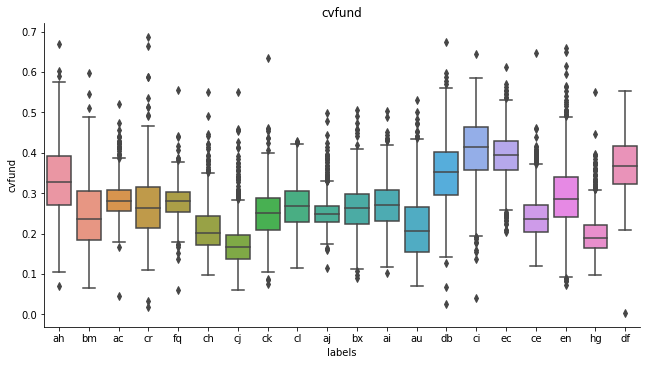

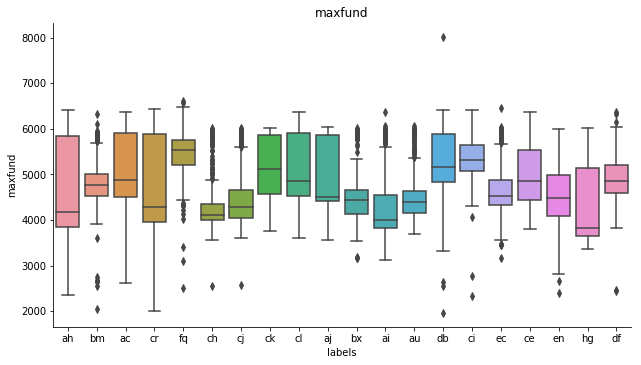

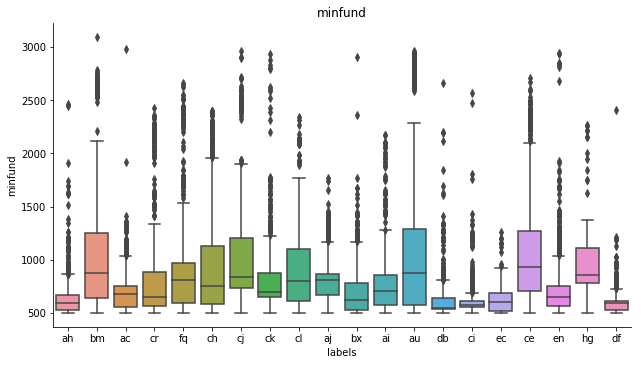

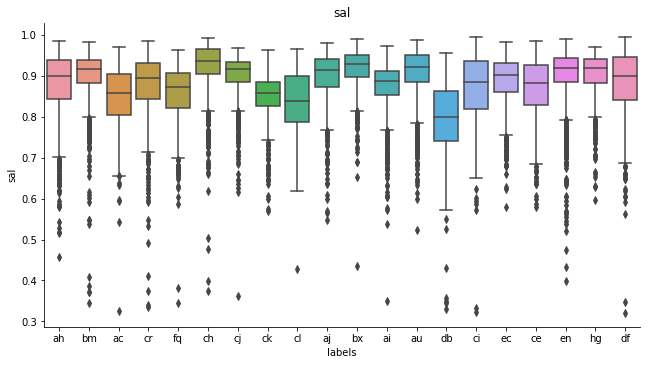

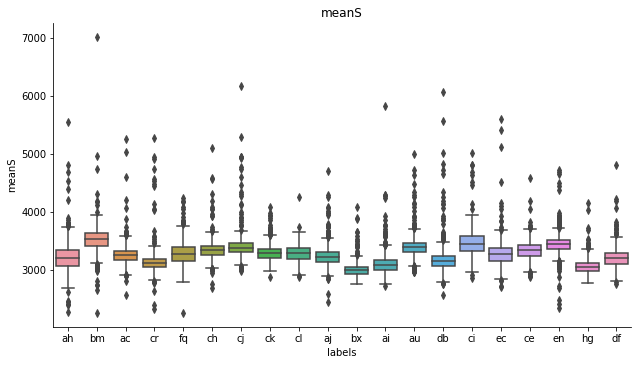

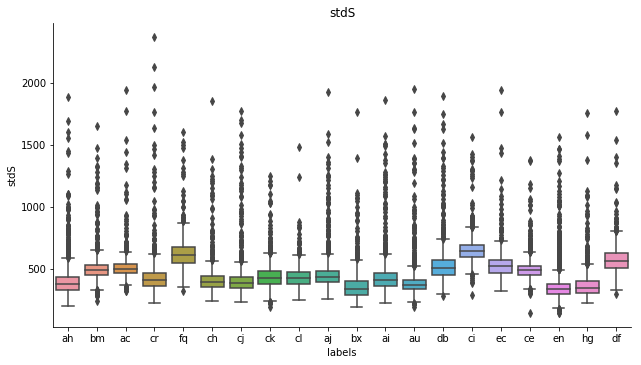

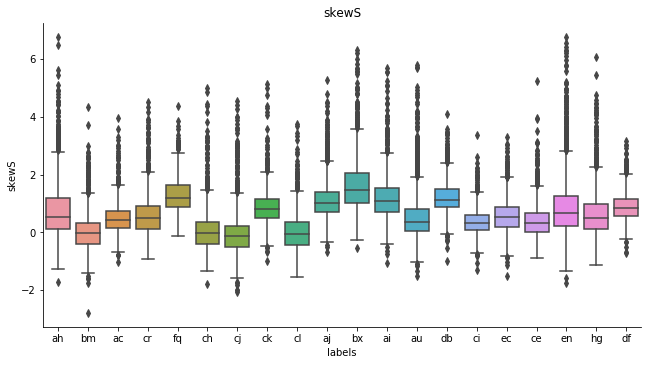

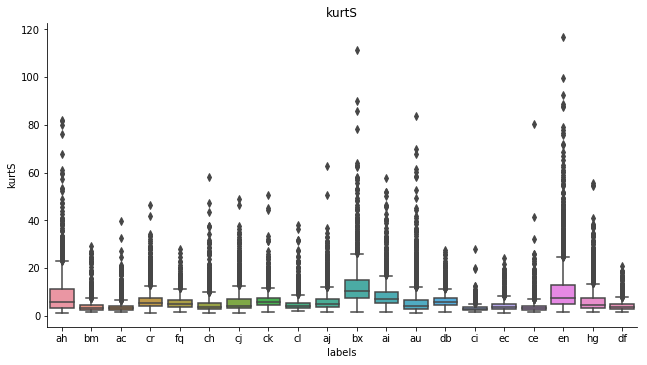

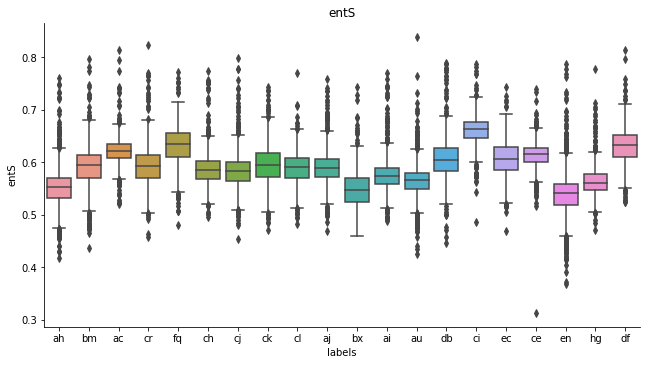

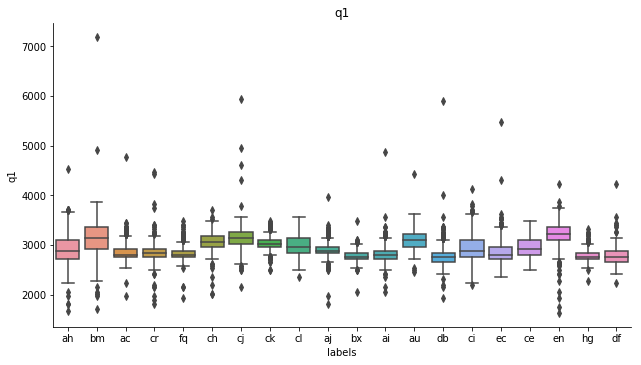

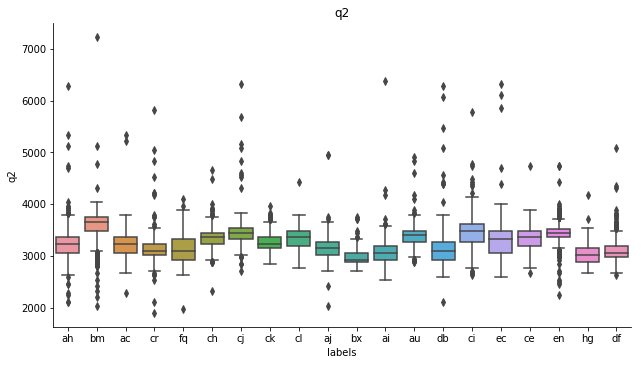

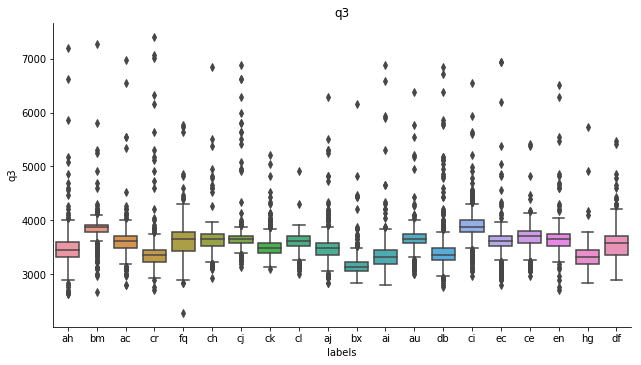

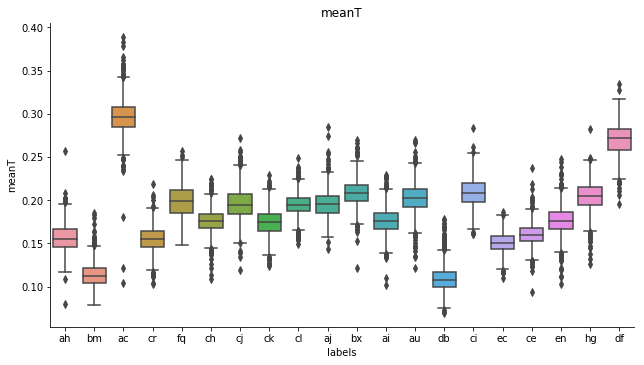

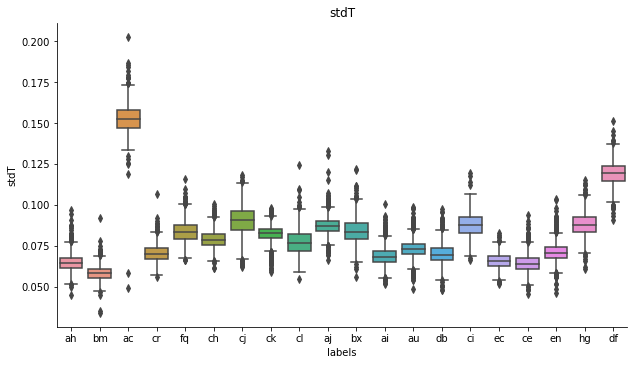

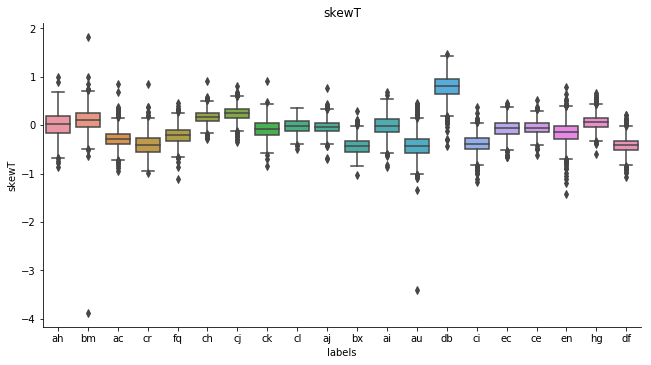

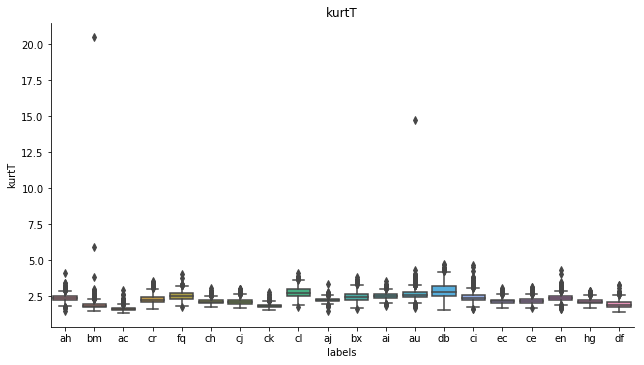

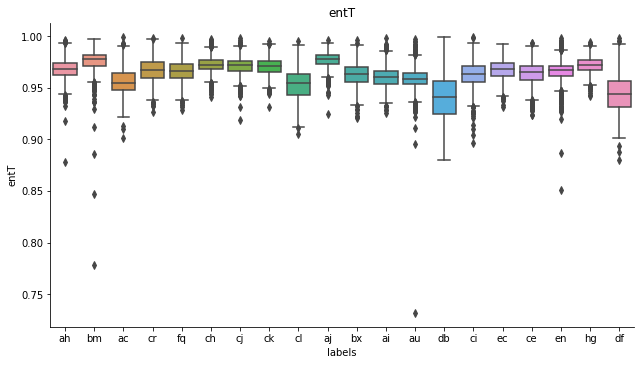

In [25]:
for feature in tqdm(features):
    test = sns.catplot(x="labels", y=feature, kind="box",
            data=subset_df);
    test.fig.set_size_inches((10,5))
    test.ax.set_title(feature)
    plt.show()

In [26]:
features_vecs = subset_df[features].values

### get labels

In [27]:
from sklearn import preprocessing

In [28]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(subset_df.labels.values)

### project features

In [29]:
cuml_umap = cumlUMAP(min_dist=0.5)
z_features = cuml_umap.fit_transform(features_vecs)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [30]:
from avgn.visualization.projections import scatter_spec

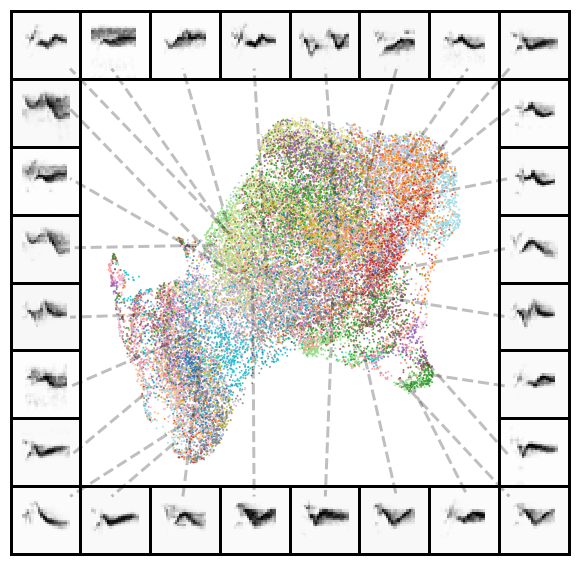

In [54]:
scatter_spec(
    z_features,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values,
        'alpha':.75,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', save_png=True, dpi=300, save_jpg=True)

### LDA

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [34]:
X = features_vecs.astype(np.float32)

In [35]:
clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(X[train_mask], y[train_mask])
z_lda = clf.transform(X[test_mask])
np.shape(z_lda)

(13391, 2)

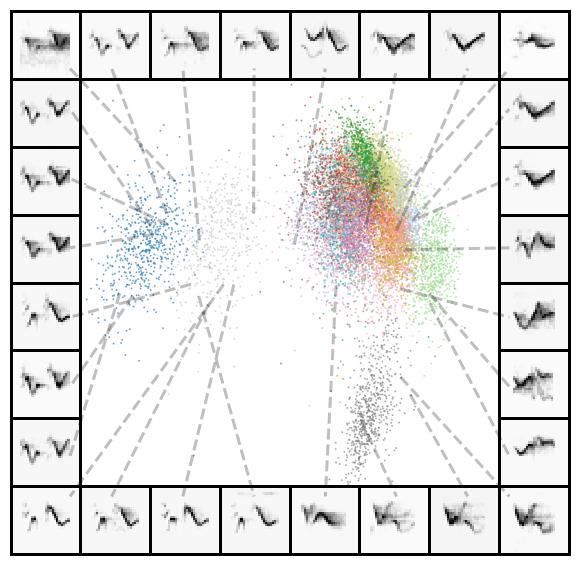

In [53]:
scatter_spec(
    z_lda,
    np.array(specs)[test_mask],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values[test_mask],
        'alpha':0.5,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'LDA_feats', dpi=300, save_png=True, save_jpg=True)

### UMAP features supervised

In [37]:
cuml_umap = cumlUMAP()#min_dist=0.5)
cuml_umap.fit(X[train_mask], y=y[train_mask])

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


UMAP(n_neighbors=15, verbose=False, handle=<cuml.common.handle.Handle object at 0x7fed8aab8180>)

In [38]:
z_features_supervised = cuml_umap.transform(X[test_mask])
np.shape(z_features_supervised)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


(13391, 2)

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 3 is coplanar with the interior point)

While executing:  | qhull v Qbb Qz Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1234613794  voronoi  Qbbound-last  Qz-infinity-point  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  Pgood  _max-width 5.3e+35
  Error-roundoff 5.7e+20  _one-merge 4e+21  Visible-distance 1.1e+21
  U-max-coplanar 1.1e+21  Width-outside 2.3e+21  _wide-facet 6.8e+21
  _maxoutside 4.5e+21

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p28(v4): 1.1e+03 1.4e+35 4.1e+35
- p14(v3): 2.4e+03 -1.2e+35 3e+34
- p7(v2): 2.4e+03 4.1e+35 3.7e+35
- p0(v1): -1.5e+02 4.1e+35 3.7e+35

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 5.7e+20.  The center point, facets and distances
to the center point are as follows:

center point     1444 2.103e+35 2.956e+35

facet p14 p7 p0 distance= -4.4e+34
facet p28 p7 p0 distance= -1e+35
facet p28 p14 p0 distance= -6.4e+02
facet p28 p14 p7 distance= -6.4e+02

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:    -152.1      2401  difference= 2553
  1:  -1.206e+35  4.089e+35  difference= 5.295e+35
  2:         0  4.089e+35  difference= 4.089e+35

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 5.7e+20.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


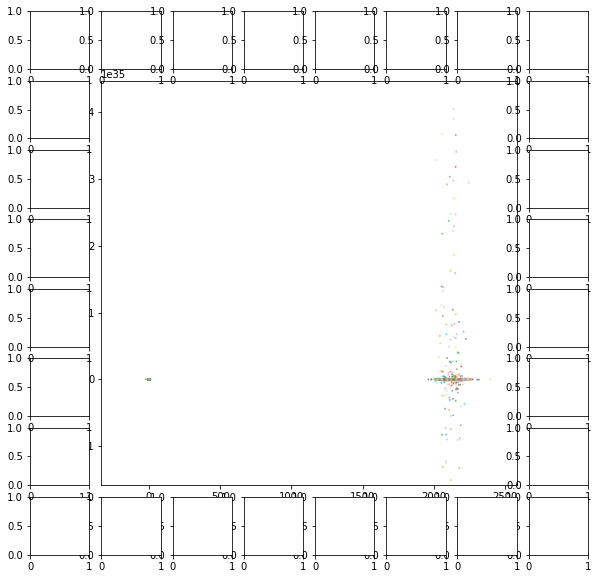

In [39]:
scatter_spec(
    z_features_supervised,
    np.array(specs)[test_mask],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values[test_mask],
        'alpha':0.5,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feat_supervised', dpi=300, save_jpg=True)

### UMAP on spectrogram

In [40]:
cuml_umap = cumlUMAP(min_dist=0.5)
z_specs_umap = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


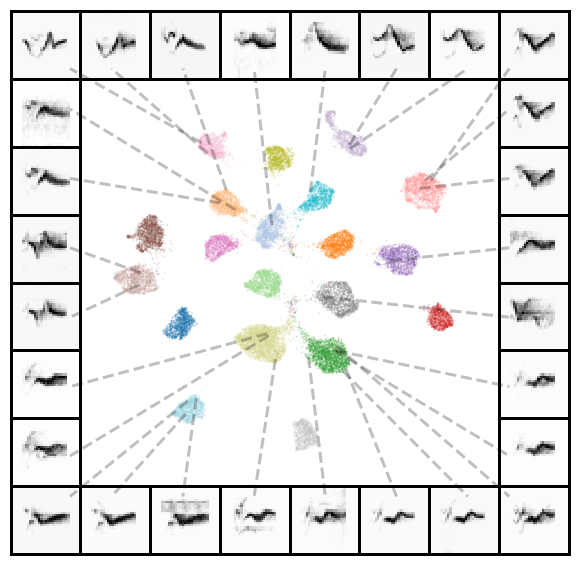

In [52]:
scatter_spec(
    z_specs_umap,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values,
        'alpha':0.15,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);

ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_spec', dpi=300, save_png=True, save_jpg=True)

### UMAP on spectrogram supervised

In [42]:
cuml_umap = cumlUMAP(min_dist=0.5)
cuml_umap.fit(specs_flattened[train_mask], y=y[train_mask])

z_specs_umap_supervised = cuml_umap.transform(specs_flattened[test_mask])
np.shape(z_specs_umap_supervised)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  after removing the cwd from sys.path.


(13391, 2)

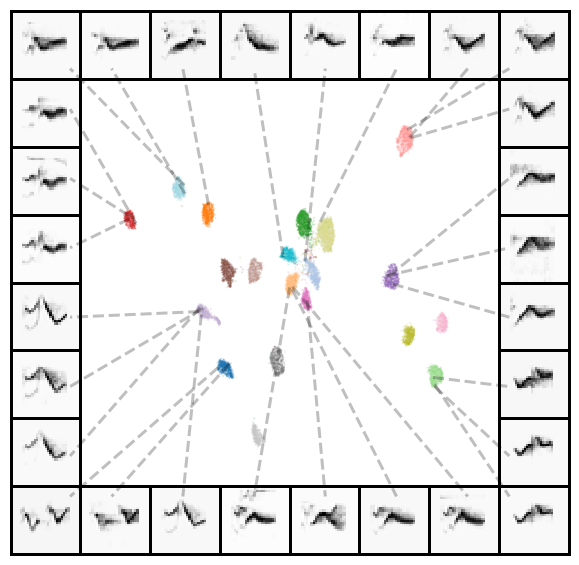

In [43]:
scatter_spec(
    z_specs_umap_supervised,
    np.array(specs)[test_mask],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values[test_mask],
        'alpha':0.15,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'umap_spec_supervised', dpi=300, save_png=True, save_jpg=True)

### LDA on spectrograms

In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [45]:
clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(specs_flattened[train_mask], y[train_mask])
z_lda_specs = clf.transform(specs_flattened[test_mask])
np.shape(z_lda_specs)

(13391, 2)

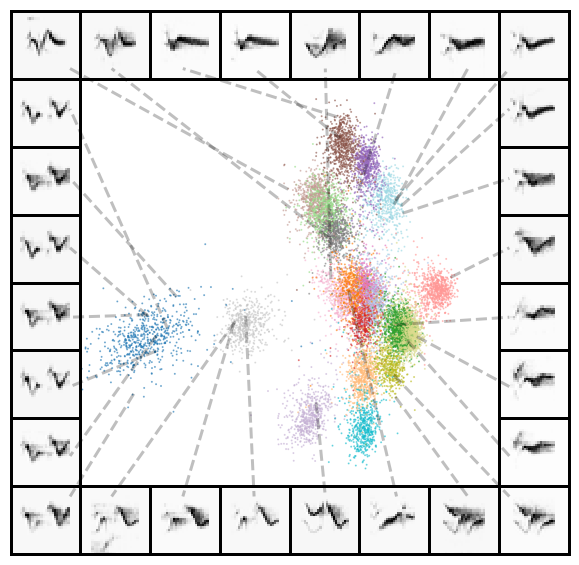

In [56]:
scatter_spec(
    z_lda_specs,
    np.array(specs)[test_mask],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.labels.values[test_mask],
        'alpha':0.5,
        's': 1,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'LDA_spec', dpi=300, save_png=True, save_jpg=True)

### how do features project onto UMAP?

fund


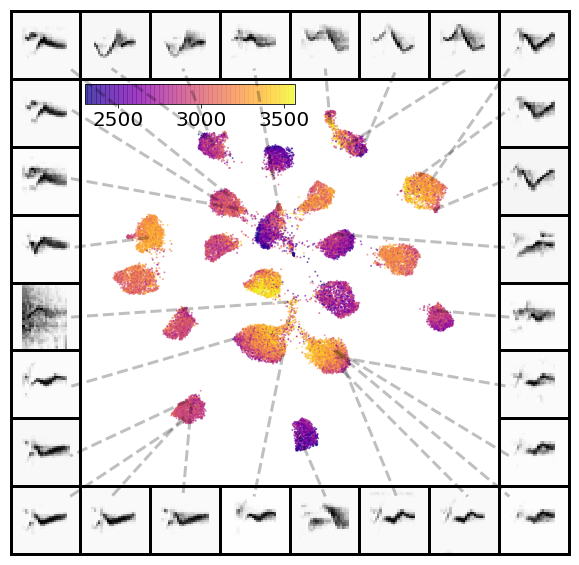

sal


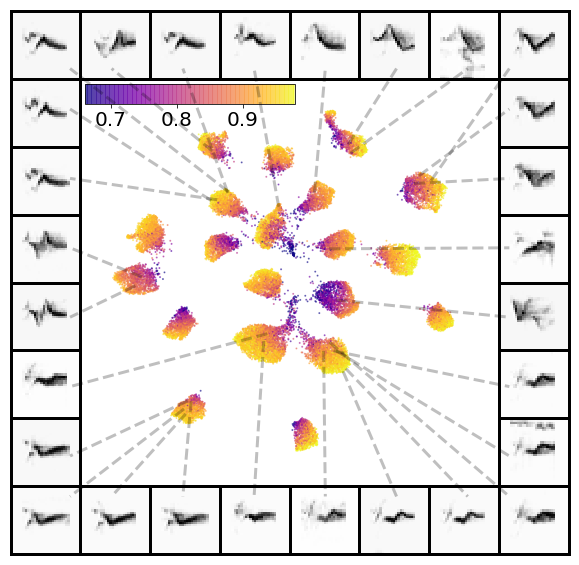

In [51]:
for feature in ["fund", "sal"]:
    print(feature)
    scatter_spec(
        z_specs_umap,
        np.array(specs),
        column_size=8,
        #x_range = [-4.5,4],
        #y_range = [-4.5,5.5],
        pal_color="hls",
        color_points=False,
        enlarge_points=0,
        figsize=(10, 10),
        range_pad = 0.15,
        scatter_kwargs = {
            'labels': subset_df[feature].values,
            'alpha':0.5,
            's': 1,
            'show_legend': True,
            "color_palette": 'plasma',
            "categorical_labels": False,
            'tick_size':20,
            'tick_pos':'bottom',
            "cbar_orientation":"horizontal"

        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':3,
            'ls':"dashed",
            'alpha':0.25,
        },
        draw_lines=True,
        n_subset= 1000,
        border_line_width = 3,

    );
    ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats' / 'feats')
    save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'feats' / feature, dpi=300, save_png = True, save_jpg=True)
    plt.show()

### Project features onto UMAP without borders

In [49]:
from avgn.visualization.projections import scatter_projections

fund


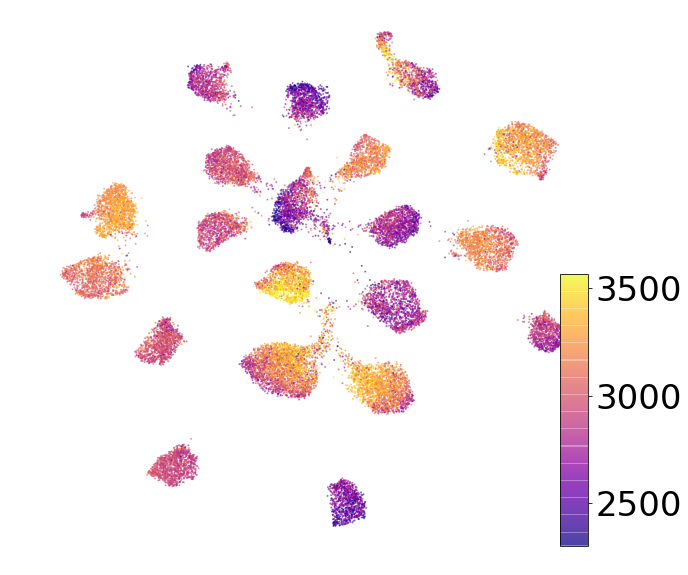

cvfund


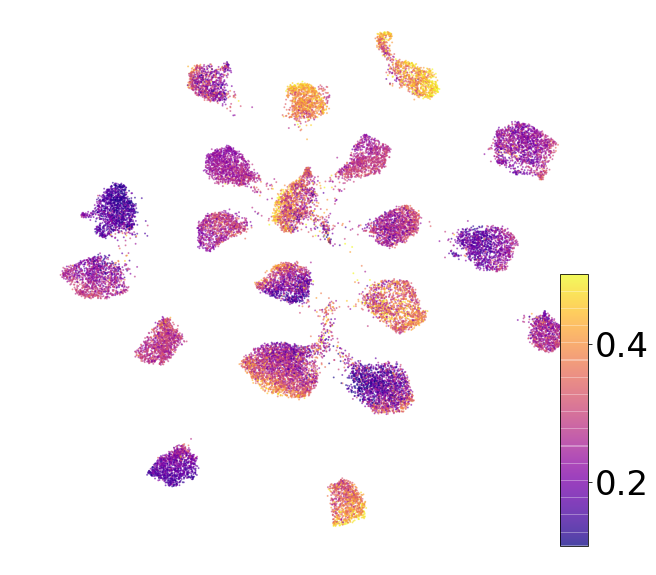

maxfund


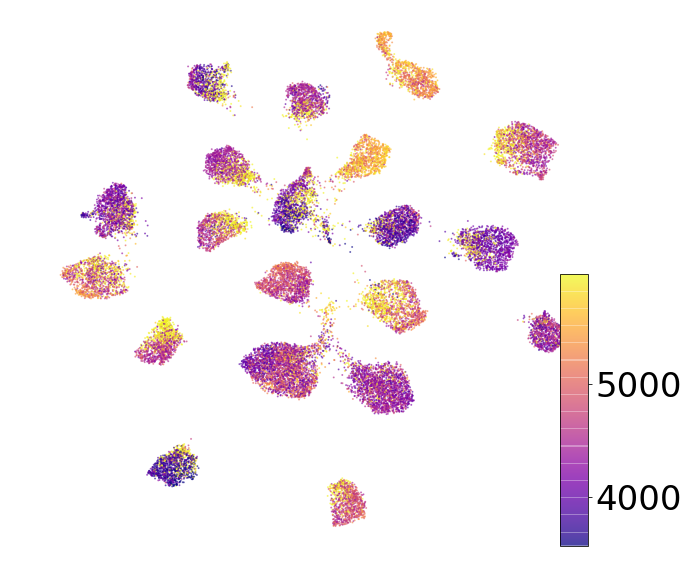

minfund


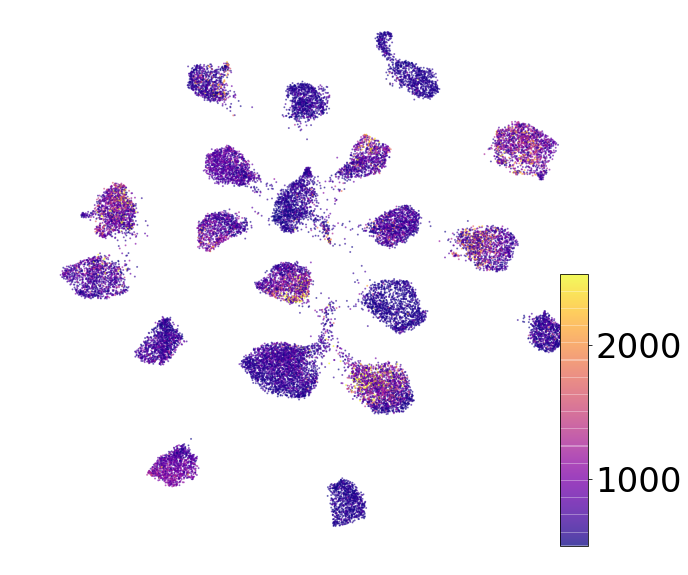

sal


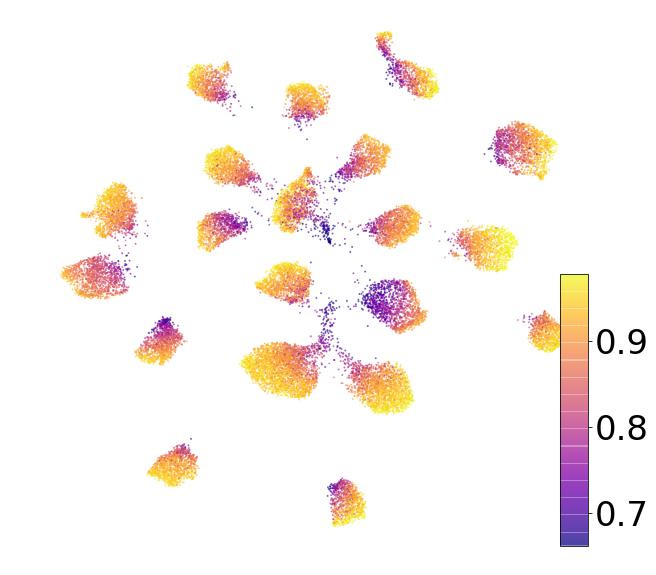

meanS


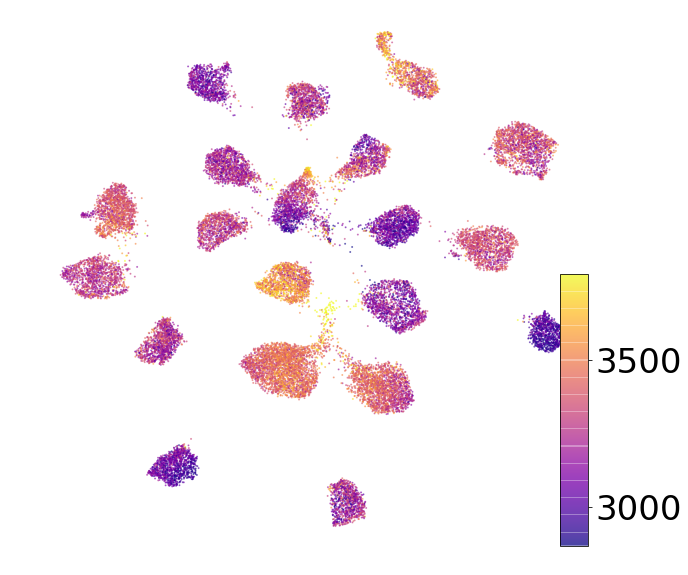

stdS


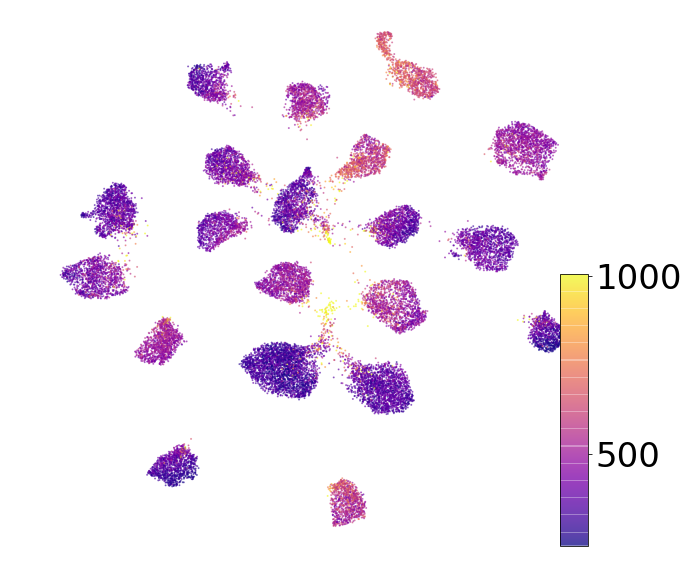

skewS


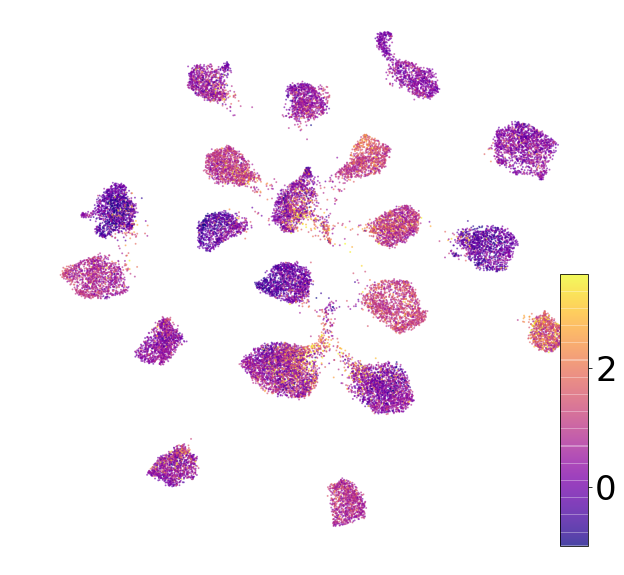

kurtS


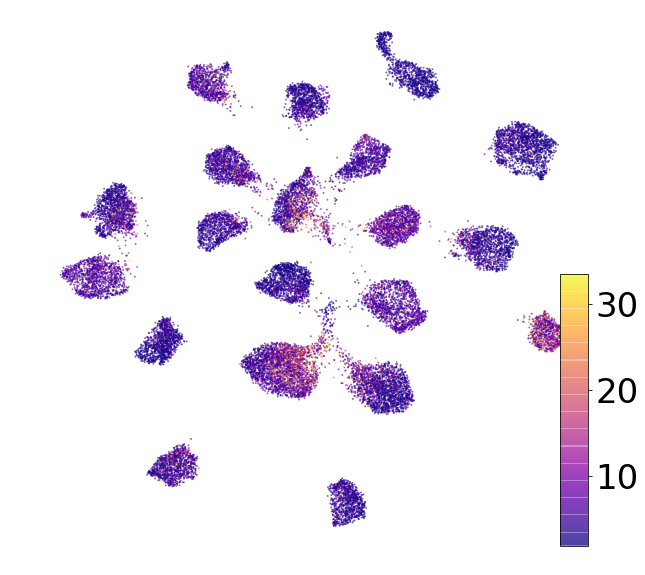

entS


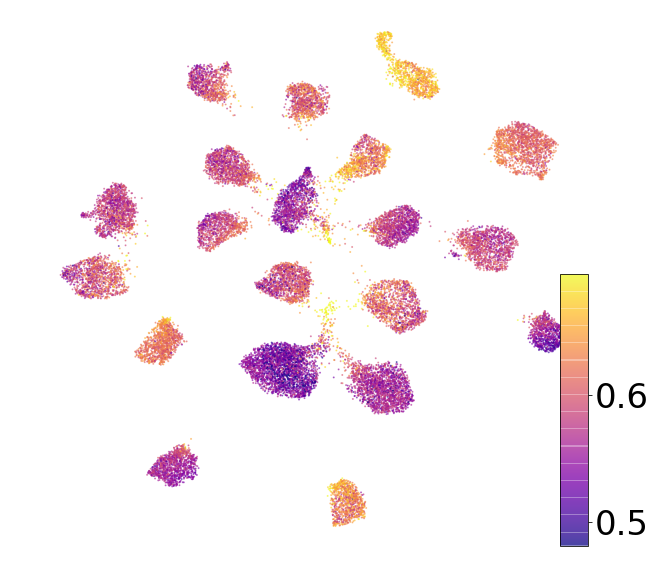

q1


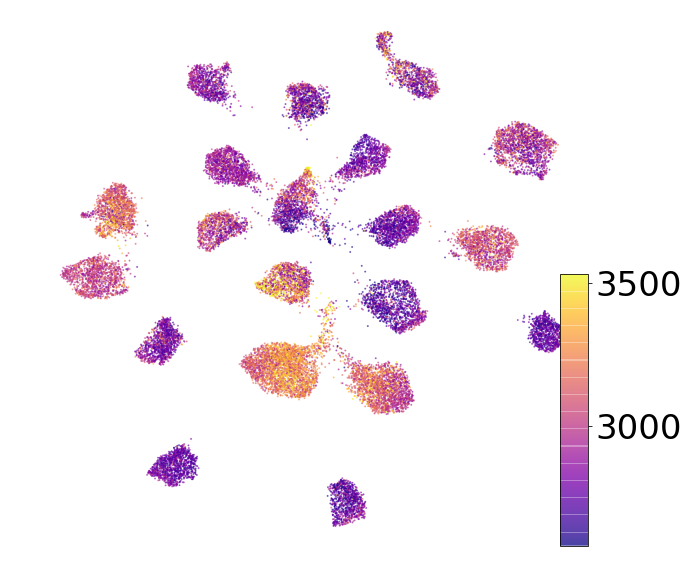

q2


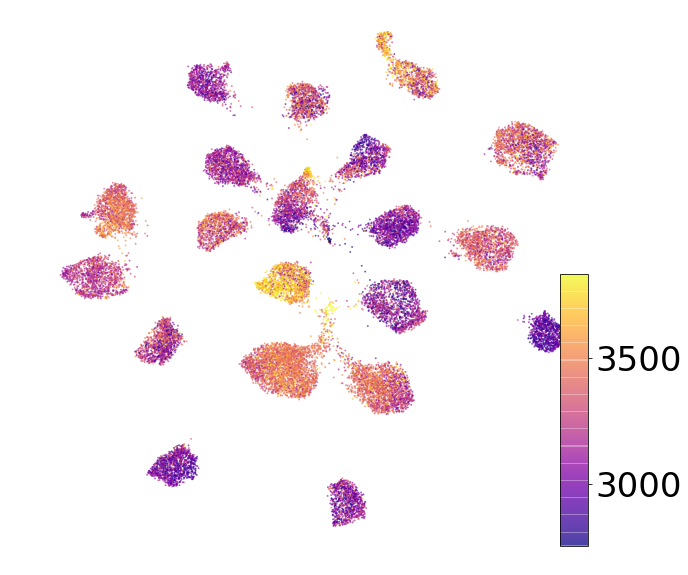

q3


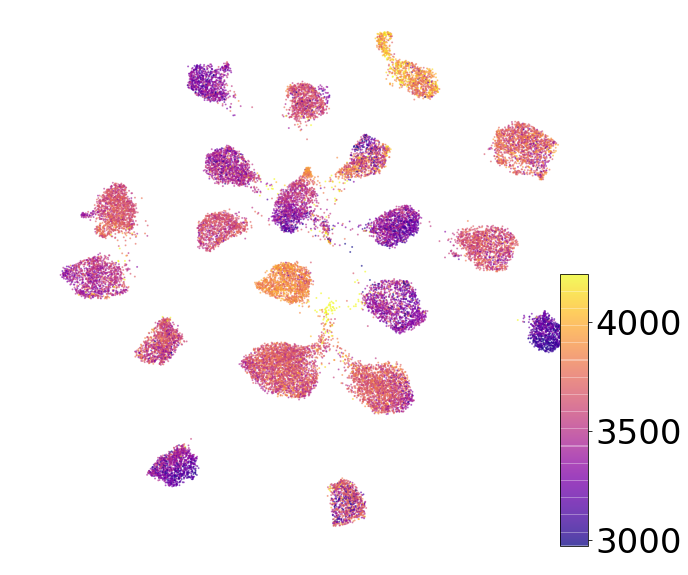

meanT


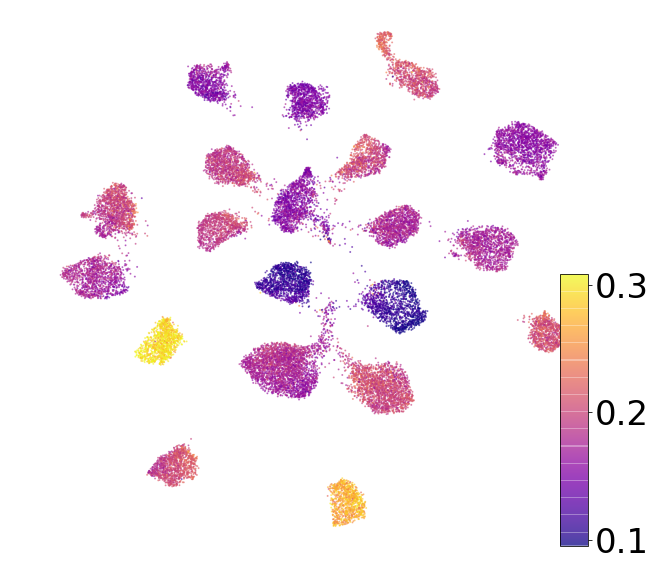

stdT


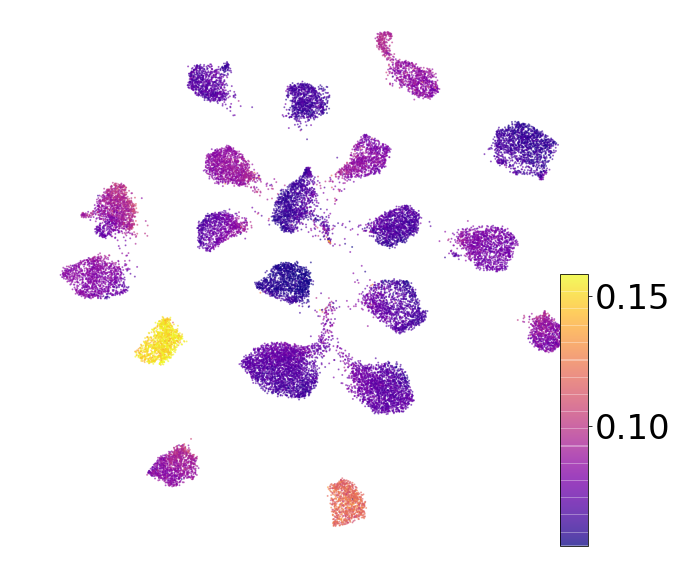

skewT


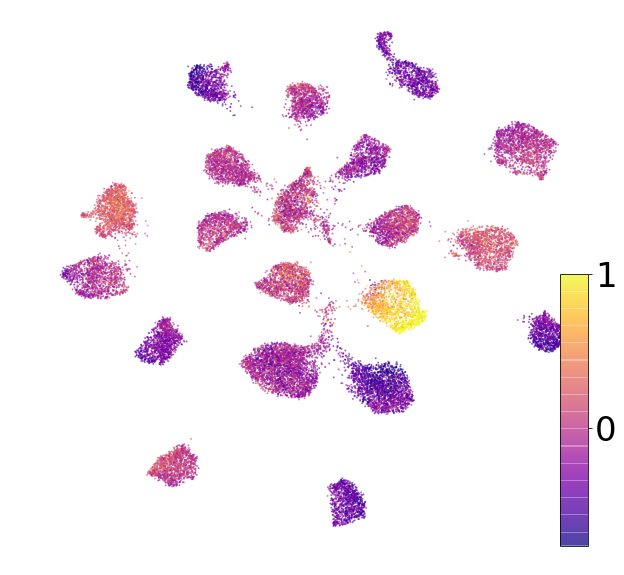

kurtT


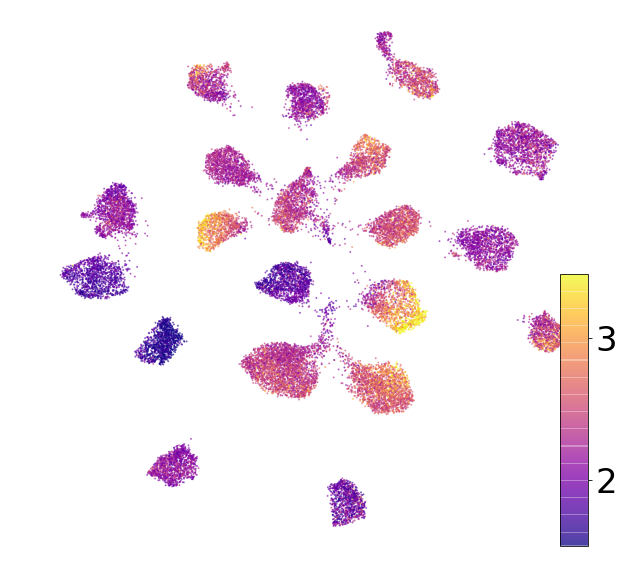

entT


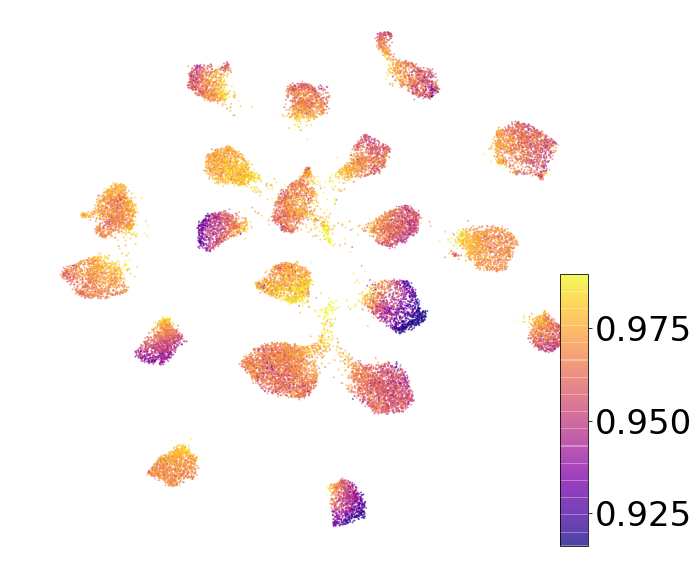

In [50]:
for feature in features:
    print(feature)
    fig, ax = plt.subplots(figsize=(10,10))
    scatter_projections(
        projection=z_specs_umap,
        ax=ax,
        fig=fig,
        labels=subset_df[feature].values,
        alpha=0.5,
        s=1,
        show_legend=True,
        color_palette='plasma',
        categorical_labels=False,
        tick_size=34,
        tick_pos='bottom',
        cbar_orientation="vertical"
    )
    ax.axis('off')
    ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats' / 'feats_noborder')
    save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'feats_noborder' / feature, dpi=300, save_jpg=True)
    plt.show()